In [ ]:
import numpy as np
import pandas as pd

# visualization import
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# define the plot size default
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)

# load specific forecasting tools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse,rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_df = pd.read_csv('/content/train.csv')
oil_df = pd.read_csv('/content/oil.csv')
store_df = pd.read_csv('/content/stores.csv')
holiday_events_df = pd.read_csv('/content/holidays_events.csv')
test_df = pd.read_csv('/content/test.csv')
sample_submission_df = pd.read_csv('/content/sample_submission.csv')
transactions_df = pd.read_csv('/content/transactions.csv')

In [ ]:
train_df = pd.read_csv('/content/train.csv',index_col=0, parse_dates=True)
train_df.index.freq = 'MS'

test_df = pd.read_csv('/content/test.csv',index_col=0, parse_dates=True)
test_df.index.freq = 'MS'

In [ ]:
train_df.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,2013-01-01,1,BABY CARE,0.0,0.0
2,2013-01-01,1,BEAUTY,0.0,0.0
3,2013-01-01,1,BEVERAGES,0.0,0.0
4,2013-01-01,1,BOOKS,0.0,0.0


In [ ]:
test_df.head()

,date,store_nbr,family,onpromotion
id,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0
3000889,2017-08-16,1,BABY CARE,0
3000890,2017-08-16,1,BEAUTY,2
3000891,2017-08-16,1,BEVERAGES,20
3000892,2017-08-16,1,BOOKS,0


In [ ]:
# check for null or missing values
train_df.isna().sum()

date           0
store_nbr      0
family         0
sales          1
onpromotion    1
dtype: int64

In [ ]:
# Remove rows with null values from the DataFrame
train_df.dropna(inplace=True)

# If you want to remove rows with null values in a specific column, you can do the following:
# train_df.dropna(subset=['column_name'], inplace=True)


In [ ]:
train_df.isna().sum()

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [ ]:
# the number of instances
len(train_df)

108851

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108851 entries, 0 to 108850
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   date         108851 non-null  object 
 1   store_nbr    108851 non-null  int64  
 2   family       108851 non-null  object 
 3   sales        108851 non-null  float64
 4   onpromotion  108851 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 5.0+ MB


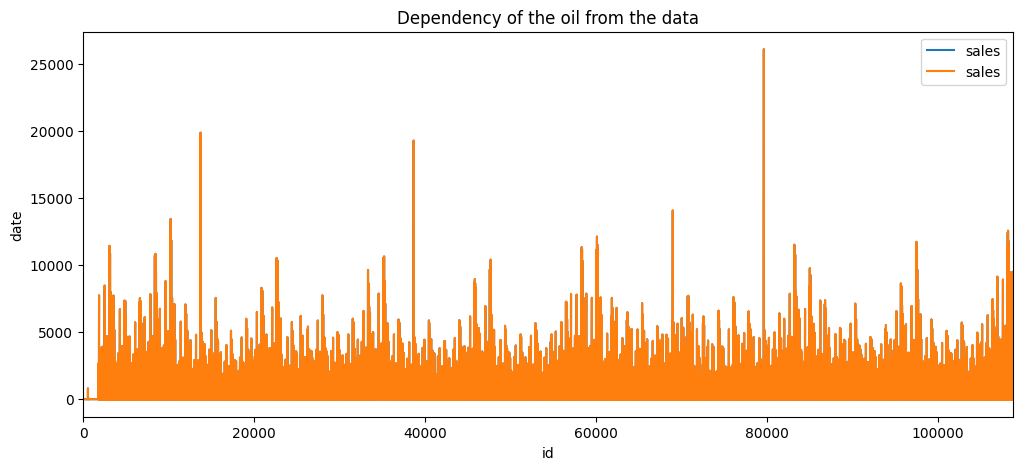

In [ ]:
title = 'Dependency of the oil from the data'
ylabel = 'date'
xlabel='' #xlabel is not required. The datetime indes will be taken as the points on the x axis

ax = train_df['sales'].plot(legend=True,title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel,ylabel=ylabel)
train_df['sales'].plot(legend=True);




In [ ]:
def dickey_fuller(series,title='Your Dataset'):
    '''Hypothesis Test for stationarity '''
    print(f'Augmented Dickey Fuller Test for the dataset {title}')

    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistics','p-value','#lags','#observations'] # use help(adfuller) to understand why these labels are chosen

    outcome = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        outcome[f'critical value ({key})'] = val

    print(outcome.to_string()) # this will not print the line 'dtype:float64'

    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis') # Ho is Data is not stationary, check help(adfuller)
        print('Reject the null hypothesis')
        print('Data is Stationary')
    else:
        print('Weak evidence against the Null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non stationary')

In [ ]:
dickey_fuller(train_df['sales'],title='sales')

Augmented Dickey Fuller Test for the dataset sales
ADF test statistics        -24.016474
p-value                      0.000000
#lags                       69.000000
#observations           108781.000000
critical value (1%)         -3.430410
critical value (5%)         -2.861567
critical value (10%)        -2.566784
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


In [ ]:
dickey_fuller(test_df['onpromotion'],title='onpromotion')

Augmented Dickey Fuller Test for the dataset onpromotion
ADF test statistics    -1.468761e+01
p-value                 3.085312e-27
#lags                   5.000000e+01
#observations           2.846100e+04
critical value (1%)    -3.430580e+00
critical value (5%)    -2.861642e+00
critical value (10%)   -2.566824e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


In [ ]:
# Select only numeric columns for differencing
numeric_columns = train_df.select_dtypes(include=[np.number])

# Apply differencing to the numeric columns
df_difference = numeric_columns.diff()


In [ ]:
# Select only numeric columns for differencing
numeric_columns = test_df.select_dtypes(include=[np.number])

# Apply differencing to the numeric columns
df_diff = numeric_columns.diff()

In [ ]:
df_difference.head()

,store_nbr,sales,onpromotion
id,,,
0,NaN,NaN,NaN
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [ ]:
df_difference = df_difference.dropna()

In [ ]:
dickey_fuller(df_difference['sales'],title='sales in training set')

Augmented Dickey Fuller Test for the dataset sales in training set
ADF test statistics        -57.901147
p-value                      0.000000
#lags                       69.000000
#observations           108780.000000
critical value (1%)         -3.430410
critical value (5%)         -2.861567
critical value (10%)        -2.566784
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


In [ ]:
dickey_fuller(df_diff['onpromotion'],title='onpromotion of testing set')

Augmented Dickey Fuller Test for the dataset onpromotion of testing set
ADF test statistics       -34.282607
p-value                     0.000000
#lags                      50.000000
#observations           28460.000000
critical value (1%)        -3.430580
critical value (5%)        -2.861642
critical value (10%)       -2.566824
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


In [ ]:
df_difference = df_difference.diff().dropna()
dickey_fuller(df_difference['sales'],title='sales 2nd Order Diff')

Augmented Dickey Fuller Test for the dataset sales 2nd Order Diff
ADF test statistics        -83.766449
p-value                      0.000000
#lags                       69.000000
#observations           108779.000000
critical value (1%)         -3.430410
critical value (5%)         -2.861567
critical value (10%)        -2.566784
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


In [ ]:
df_diff = df_diff.diff().dropna()

In [ ]:
dickey_fuller(df_diff['onpromotion'],title='onpromotion 2nd Order Diff')

Augmented Dickey Fuller Test for the dataset onpromotion 2nd Order Diff
ADF test statistics       -55.631581
p-value                     0.000000
#lags                      50.000000
#observations           28459.000000
critical value (1%)        -3.430580
critical value (5%)        -2.861642
critical value (10%)       -2.566824
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


In [ ]:
df_diff.head()

,store_nbr,onpromotion
id,,
3000890,0.0,2.0
3000891,0.0,16.0
3000892,0.0,-38.0
3000893,0.0,32.0
3000894,0.0,-24.0


In [ ]:
len(df_diff)

28510

In [ ]:
nobs = 12
train = df_diff[:-nobs]
test = df_diff[-nobs:]

In [ ]:
len(train), len(test)

(28498, 12)

In [ ]:
print(df_diff)

         store_nbr  onpromotion
id                             
3000890        0.0          2.0
3000891        0.0         16.0
3000892        0.0        -38.0
3000893        0.0         32.0
3000894        0.0        -24.0
...            ...          ...
3029395        0.0          1.0
3029396        0.0         -2.0
3029397        0.0          2.0
3029398        0.0          7.0
3029399        0.0        -17.0

[28510 rows x 2 columns]


VAR model selection

In [ ]:
p = [1,2,3,4,5,6,7]  # try with list of 7 p values

for i in p:
    model = VAR(df_diff)
    results = model.fit(i)
    print(f'VAR Order {i}')
    print('AIC {}'.format(results.aic))
    print('BIC {}'.format(results.bic))
    print()

VAR Order 1
AIC 9.509458118849743
BIC 9.511196091091325

VAR Order 2
AIC 9.139176717149123
BIC 9.142073426854688

VAR Order 3
AIC 8.875547298116635
BIC 8.879602816736687

VAR Order 4
AIC 8.669036808543632
BIC 8.674251207535686

VAR Order 5
AIC 8.505270799845201
BIC 8.511644150673765

VAR Order 6
AIC 8.398378060974954
BIC 8.405910435111545

VAR Order 7
AIC 8.356615255295006
BIC 8.365306724218145



Fit the VAR(5) model

In [ ]:
results = model.fit(5)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 06, Nov, 2023
Time:                     08:23:48
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    8.51164
Nobs:                     28505.0    HQIC:                   8.50732
Log likelihood:          -202093.    FPE:                    4940.74
AIC:                      8.50527    Det(Omega_mle):         4936.93
--------------------------------------------------------------------
Results for equation store_nbr
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.000000         0.015889            0.000           1.000
L1.store_nbr          -0.833190         0.005841         -142.639           0.000
L1.onpromotion        -0.000222         0.000567    

Predict the next 12 values

In [ ]:
lag_order = results.k_ar
lag_order

5

In [ ]:
z = results.forecast(y=train.values[-lag_order:],steps = 12)
z

array([[ 1.35019905e-02,  2.01254312e+00],
       [-1.48822941e-02, -2.02507166e+00],
       [ 1.38500344e-03, -4.34629598e-01],
       [ 2.45321836e-03,  2.88948086e-02],
       [-7.19841592e-04, -9.35531819e-01],
       [ 2.33328571e-03,  2.95077764e+00],
       [ 8.71571878e-04, -1.84937082e+00],
       [-6.08053052e-03, -4.64216998e-01],
       [ 4.01754803e-03,  4.45078698e-01],
       [ 1.75920573e-04,  2.78391994e-01],
       [-3.44207234e-04,  6.75949557e-02],
       [-1.53457397e-06, -5.63219604e-02]])

In [ ]:
test_df

,date,store_nbr,family,onpromotion
id,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0
3000889,2017-08-16,1,BABY CARE,0
3000890,2017-08-16,1,BEAUTY,2
3000891,2017-08-16,1,BEVERAGES,20
3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...
3029395,2017-08-31,9,POULTRY,1
3029396,2017-08-31,9,PREPARED FOODS,0
3029397,2017-08-31,9,PRODUCE,1


In [ ]:
idx = pd.date_range(start='1/1/2015',periods=12,freq='MS')
df_forecast = pd.DataFrame(z,index=idx,columns=['sales2D','onpromotion2D'])

In [ ]:
df_forecast[:5]

,sales2D,onpromotion2D
2015-01-01,0.013502,2.012543
2015-02-01,-0.014882,-2.025072
2015-03-01,0.001385,-0.434630
2015-04-01,0.002453,0.028895
2015-05-01,-0.000720,-0.935532


Invert the Transformations

In [ ]:
df_forecast['sales1D'] = (train_df['sales'].iloc[-nobs-1] - train_df['sales'].iloc[-nobs-2]) + df_forecast['sales2D'].cumsum()

In [ ]:
# Now build the forecast values from the first difference set
df_forecast['salesForecast'] = train_df['sales'].iloc[-nobs-1] + df_forecast['sales1D'].cumsum()

In [ ]:
df_forecast

,sales2D,onpromotion2D,sales1D,salesForecast
2015-01-01,0.013502,2.012543,-749.986498,-749.986498
2015-02-01,-0.014882,-2.025072,-750.001380,-1499.987878
2015-03-01,0.001385,-0.434630,-749.999995,-2249.987874
2015-04-01,0.002453,0.028895,-749.997542,-2999.985416
2015-05-01,-0.000720,-0.935532,-749.998262,-3749.983678
2015-06-01,0.002333,2.950778,-749.995929,-4499.979606
2015-07-01,0.000872,-1.849371,-749.995057,-5249.974663
2015-08-01,-0.006081,-0.464217,-750.001138,-5999.975801
2015-09-01,0.004018,0.445079,-749.997120,-6749.972921
2015-10-01,0.000176,0.278392,-749.996944,-7499.969865


Similarly,lets do this for the onpromotion column

In [ ]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['onpromotion1D'] = (test_df['onpromotion'].iloc[-nobs-1]-test_df['onpromotion'].iloc[-nobs-2]) + df_forecast['onpromotion2D'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['onpromotionForecast'] = test_df['onpromotion'].iloc[-nobs-1] + df_forecast['onpromotion1D'].cumsum()

In [ ]:
df_forecast

,sales2D,onpromotion2D,sales1D,salesForecast,onpromotion1D,onpromotionForecast
2015-01-01,0.013502,2.012543,-749.986498,-749.986498,2.012543,2.012543
2015-02-01,-0.014882,-2.025072,-750.001380,-1499.987878,-0.012529,2.000015
2015-03-01,0.001385,-0.434630,-749.999995,-2249.987874,-0.447158,1.552856
2015-04-01,0.002453,0.028895,-749.997542,-2999.985416,-0.418263,1.134593
2015-05-01,-0.000720,-0.935532,-749.998262,-3749.983678,-1.353795,-0.219202
2015-06-01,0.002333,2.950778,-749.995929,-4499.979606,1.596982,1.377780
2015-07-01,0.000872,-1.849371,-749.995057,-5249.974663,-0.252388,1.125392
2015-08-01,-0.006081,-0.464217,-750.001138,-5999.975801,-0.716605,0.408787
2015-09-01,0.004018,0.445079,-749.997120,-6749.972921,-0.271527,0.137260
2015-10-01,0.000176,0.278392,-749.996944,-7499.969865,0.006865,0.144126


Plot the results

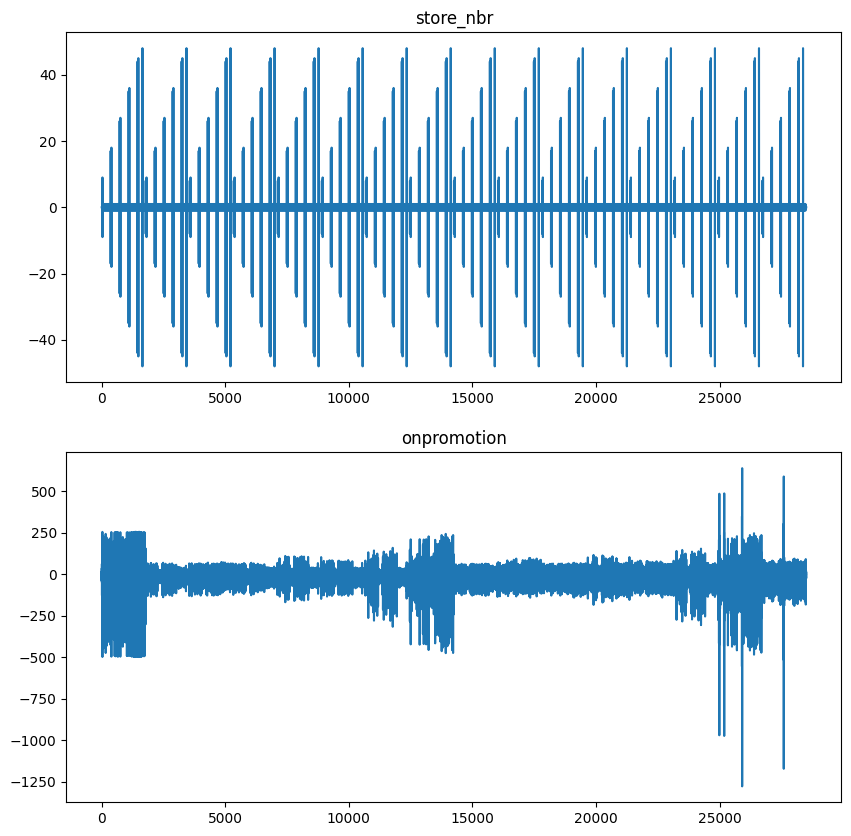

In [ ]:
results.plot();

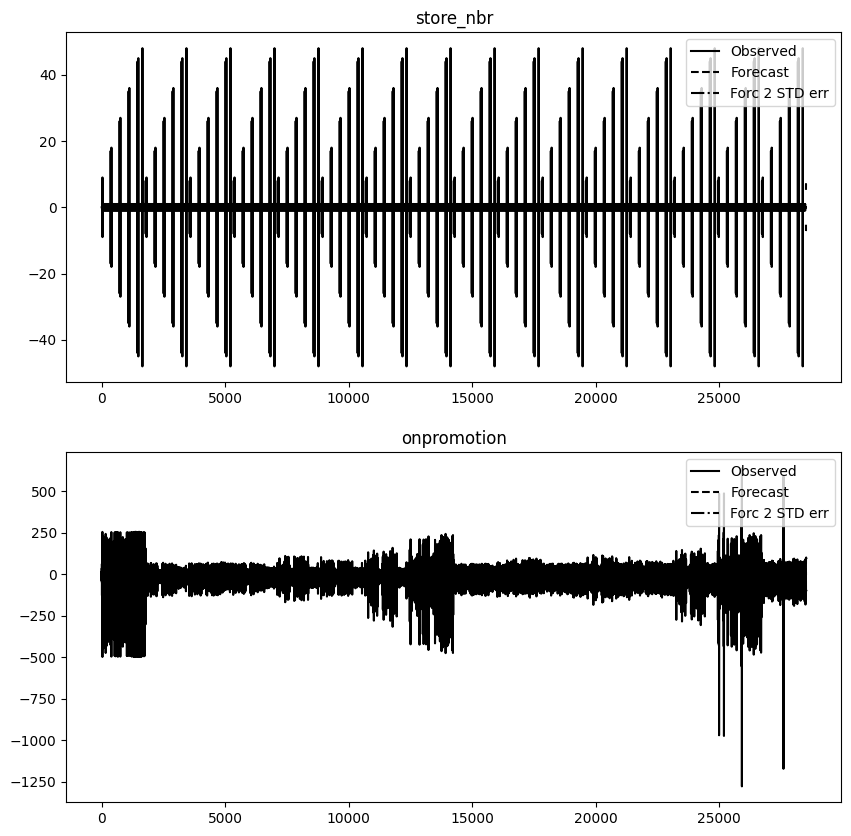

In [ ]:
results.plot_forecast(12);

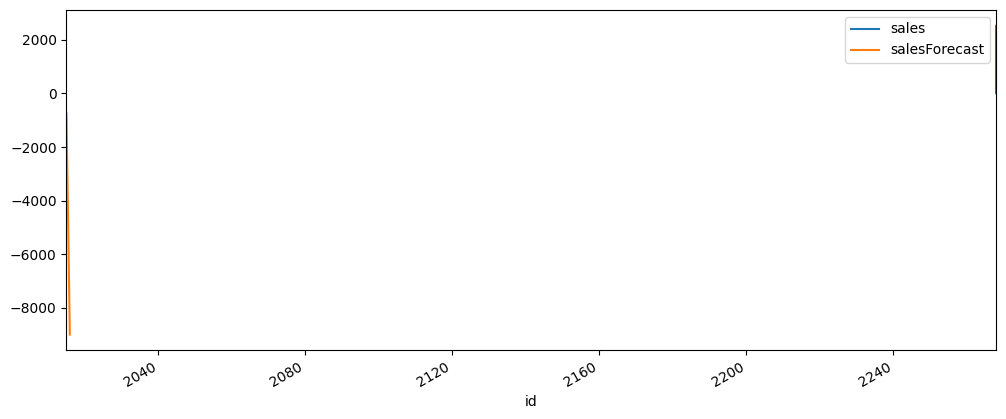

In [ ]:
train_df['sales'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['salesForecast'].plot(legend=True);

Model Evaluation

In [ ]:
RMSE1 = rmse(train_df['sales'][-nobs:], df_forecast['salesForecast'])
print(f'sales VAR(5) RMSE: {RMSE1:.3f}')

sales VAR(5) RMSE: 5851.220


In [ ]:
RMSE2 = rmse(test_df['onpromotion'][-nobs:], df_forecast['onpromotionForecast'])
print(f'onpromotion VAR(5) RMSE: {RMSE2:.3f}')

onpromotion VAR(5) RMSE: 7.320
